In [1]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
#import torchaudio.transforms as T
import sys

import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/kws_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Run pytorch on M1 GPU

In [3]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())


# To run PyTorch code on the GPU, use torch.device("mps") analogous to torch.device("cuda") on an Nvidia GPU.
dtype = torch.float
device = torch.device("mps")
print(device)


True
True
mps


#### This is only for non-M1 devices:
Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [49]:
# 1) source:https://arxiv.org/pdf/1804.03209.pdf 
# 2) the pytorch dataset is actually close form of tensorflow speech dataset: 
# https://pytorch.org/audio/stable/_modules/torchaudio/datasets/speechcommands.html

# 3) https://www.tensorflow.org/datasets/catalog/speech_commands
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC_v2(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]



## EDA 

### Size of each subsets

In [57]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC_v2("training")
validation_set = SubsetSC_v2("validation")
test_set = SubsetSC_v2("testing")

print("Number of Examples in train set:", len(train_set))
print("Number of Examples in validation set:", len(validation_set))
print("Number of Examples in test set:", len(test_set))

Number of Examples in train set: 84843
Number of Examples in validation set: 9981
Number of Examples in test set: 11005


### Number of Labels in train set

In [60]:
labels_train = sorted(list(set(datapoint[2] for datapoint in train_set)))
speaker_id
spk_id_train = sorted(list(set(datapoint[3] for datapoint in train_set)))
print("length of labels in train set is= ", len(labels_train))
print("train labels are: ", labels_train)


length of labels in train set is=  35
train labels are:  ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [59]:
print(" number of speakers:", len(spk_id_train))

 number of speakers: 2112


In [53]:
### Number of Labels in validation set

In [54]:
labels_validation = sorted(list(set(datapoint[2] for datapoint in validation_set)))

print("length of labels in train set is= ", len(labels_validation))
print("validation labels are: ", labels_validation)


length of labels in train set is=  35
validation labels are:  ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [55]:
### Number of Labels in test set

In [56]:
labels_test = sorted(list(set(datapoint[2] for datapoint in test_set)))

print("length of labels in test set is= ", len(labels_test))
print("test labels are: ", labels_test)



length of labels in test set is=  35
test labels are:  ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


### Analyzing the 1st example from train set:

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




backward
Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


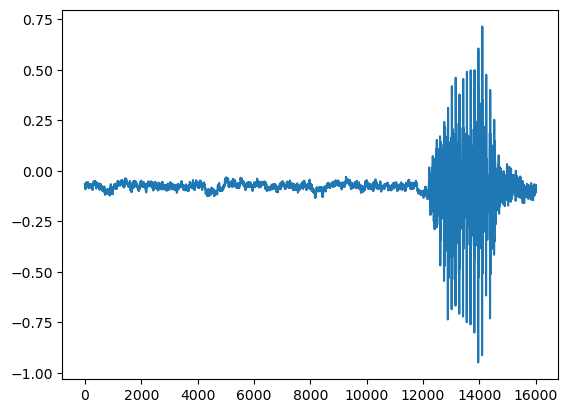

In [10]:
wav, orig_fs, label, speaker_id, utterance_number = train_set[0]
print(label)
print("Shape of waveform: {}".format(wav.size()))
print("Sample rate of waveform: {}".format(orig_fs))

plt.plot(wav.t().numpy());

Let’s find the list of labels available in the dataset.




### Playing some audio form train set:
The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [11]:
wav_1st, *_ = train_set[0]
ipd.Audio(wav_1st.numpy(), rate=orig_fs)


In [12]:
 wav_2nd, *_ = train_set[1]
ipd.Audio(wav_2nd.numpy(), rate=orig_fs)

The last file is someone saying “zero”.




In [15]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=orig_fs)

## EDA

In [29]:
# ref: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#specaugment


class dataProcess:
    #def __init__ (self, target_fs):
        #self.fs = target_fs
        
    def resample_audio (self, wav, orig_fs, target_fs):
        transform_resample = torchaudio.transforms.Resample(orig_freq=orig_fs, new_freq=target_fs)
        return transform_resample(wav)
    
    def get_spectrogram (self, wav):
        # Define transform
        spectrogram = torchaudio.transforms.Spectrogram()
        return spectrogram(wav)
        
    def apply_TimeStretch (self, spec,rate):
        stretch = torchaudio.transforms.TimeStretch()
        return stretch(spec, rate)
    
    def apply_FrequencyMasking (self, spec, f_mask_rate):
        f_masking = torchaudio.transforms.FrequencyMasking(f_mask_rate)
        return f_masking(spec)
    
    def apply_TimeMasking (self, spec, t_mask_rate):
        t_masking = torchaudio.transforms.TimeMasking(t_mask_rate)
        return t_masking(spec)

    

### Augmentation for an exmaple in train set:

In [31]:
fs = 16000 # target fs
wav, *_ = train_set[0]
dp = dataProcess()

# resampling data
wav_resampled = dp.resample_audio(wav, orig_fs, fs) 

# here the resample audio
ipd.Audio(wav_resampled.numpy(), rate=fs)

# convert audio (in time-domain) to time-freq. features. In this case spectrogram:
spec = dp.get_spectrogram(wav_resampled ) 

# Apply SpecAugment augmentation technique
ts_rate=0.9
f_mask_rate=40
t_mask_rate= 40

spec_ts = dp.apply_TimeStretch(spec[0,:,:], ts_rate) #
spec_feqM = dp.apply_FrequencyMasking(spec, f_mask_rate) 
spec_timeM = dp.apply_TimeMasking(spec, t_mask_rate) 
spec_augment = dp.apply_FrequencyMasking(spec_timeM, f_mask_rate) 

print("shape of spectrogram: ",spec.shape)
print("shape of spec_ts", spec_ts.shape)
print("shape of spec_augment", spec_augment.shape)

shape of spectrogram:  torch.Size([1, 201, 81])
shape of spec_ts torch.Size([201, 90])
shape of spec_augment torch.Size([1, 201, 81])


### Plot result of data augmentation

In [44]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

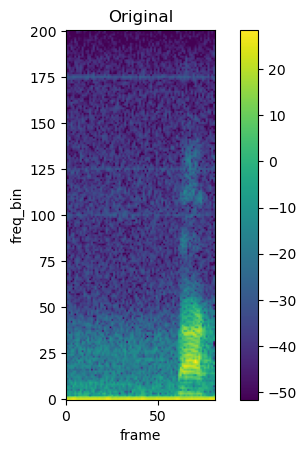

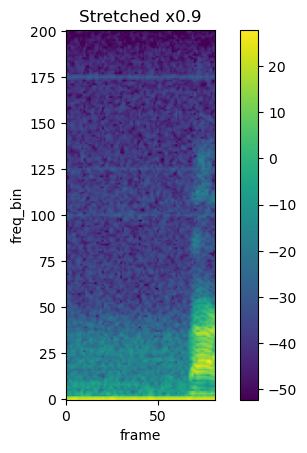

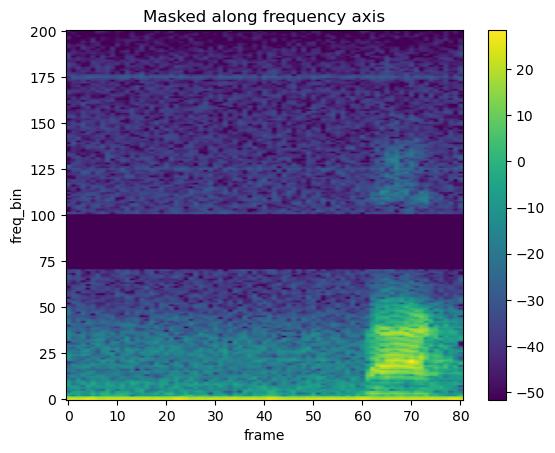

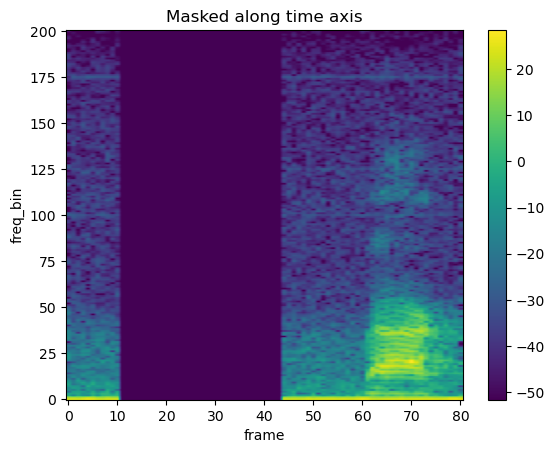

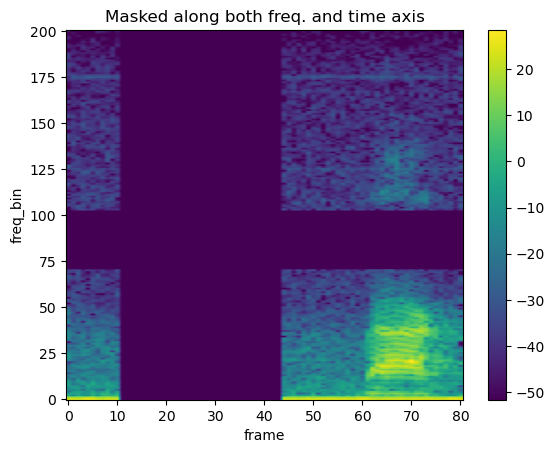

In [48]:
#fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

plot_spectrogram( torch.abs(spec[0,:,:]), title="Original", aspect="equal", xmax=spec.shape[2])

plot_spectrogram( torch.abs(spec_ts), title=f"Stretched x{ts_rate}", aspect="equal", xmax=spec.shape[2])

plot_spectrogram( spec_feqM[0,:,:], title="Masked along frequency axis")

plot_spectrogram( spec_timeM[0,:,:], title="Masked along time axis")

plot_spectrogram( spec_augment[0,:,:], title="Masked along both freq. and time axis")

#plt.tight_layout()

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.


